# **Составление частотного словаря слов ненецкого языка (по материалам постов социальной сети VK и статьям на сайте)**

## **Постановка задачи**

Реализация частотного словаря слов позволит определить актуальный набор слов ненецкого языка, которыми необходимо наполнить [разрабатываемый онлайн-словарь](https://nenrusdict.narfu.ru/) для языковых пар русский-ненецкий и ненецкий-русский в первую очередь, с помощью собранного набора данных на лесном ненецком языке.

[Подробнее](https://www.elibrary.ru/item.asp?id=65600587) про сбор данных и
построение векторной модели с определением контекстной близости слов.

## **Составление набора данных**

Для составления набора данных использовались следующие источники на лесном
ненецком языке:

*   [сообщество](https://vk.com/nn.yanao) общественно-политической
национальной газеты Ямало-Ненецкого автономного округа "Няръяна Нгэрм" и
[сообщество](https://vk.com/club173849556) газеты для носителей лесного
диалекта ненецкого языка в социальной сети ВКонтакте;
*   [страница](http://www.yamalexpedition.ru/nen/blog-nen) дневниковых записей
и [страница](http://www.yamalexpedition.ru/nen/education-for-nomads-nen) на
тему кочевого образования на сайтеэтнографической экспедиции "Настоящие люди".

### **VK API**

Программный код для сбора текста постов в социальной сети ВКонтакте на
примере сообщества "Няръяна Нгэрм - старейшая газета Ямала":

```
import requests
import csv

access_token = 'API-key'
group_id = '147614552'
version = '5.131'

url = f'https://api.vk.com/method/wall
.get?group_id=-{group_id}&access_token={access_token}&v={version}'

# Отправление GET-запроса и получение JSON-объекта с данными
response = requests.get(url)
data = response.json()

if 'response' not in data:
    print(data['запрос не прошел успешно'])
else:
    # Получение общего числа постов в группе
    count = data['response']['count']
    print(f'Количество постов: {count}')

    # Получение всех постов на стене группы
    posts = []
    offset = 0
    while offset < count:
        url = f'https://api.vk.com/method/wall
.get?group_id=-{group_id}&offset={offset}&count=100&access_token
={access_token}&v={version}'
        response = requests.get(url)
        data = response.json()
        posts.extend(data['response']['items'])
        offset += 100

    print(f'Количество собранных постов: {len(posts)}')

    # Сохранение данных в CSV-файл
    with open('nn_yanao_posts.csv', 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['link', 'text'])
        for post in posts:
            post_link = f'https://vk.com/wall-{group_id}_{post["id"]}'
            post_text = post.get('text', '')

            # Преобразование текстовых элементов в строку между ссылками на
посты
            text_lines = post_text.split('\n')
            combined_text = ''
            for line in text_lines:
                if not line.startswith('http'):
                    combined_text += line.strip() + ' '

            writer.writerow([post_link, combined_text.strip()])

    print('Данные о постах сохранены в nn_yanao_posts.csv')
```

Данный код формирует файл в формате csv с названием "nn_yanao_posts" с
разметкой признаков 'link' и 'text' и записями, которые содержат текст
преимущественно на ненецком языке в сообществе "Няръяна Нгэрм - старейшая
газета Ямала". Записи могут не иметь текста (например, в том случае, если
запись в социальной сети опубликована только с медиа-материалом, без текста)
 или иметь несколько абзацев в одной записи. Запись может содержать текст
 как полностью на ненецком языке, так и на русском.

Аналогичным способом с помощью VK API были собраны данные из другого
сообщества газеты для носителей лесного диалекта ненецкого языка в файл
nn_yanao_posts_2.csv.

### **Requests & BeautifulSoup**

Программный код для сбора текста в статьях сайта об этнографической
экспедиции «Настоящие люди»:

```
import requests
from bs4 import BeautifulSoup
import csv

url = "http://www.yamalexpedition.ru/nen/blog-nen/"

response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# Нахождение всех элементов с классом "show-comment", содержащих ссылки на
полные версии статей
links = soup.find_all("span", {"class": "show-comment"})

with open('articles_yamal_expedition.csv', 'w', encoding='utf-8',
newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['link', 'title', 'text'])

    for link in links:
        # Так как ссылки в html указаны без полного пути, ссылки
модифицированы
        article_url = 'http://www.yamalexpedition.ru' + link.find("a")["href"]

        article_response = requests.get(article_url)
        article_soup = BeautifulSoup(article_response.text, "html.parser")

        article_title = article_soup.find('div', {'class': 'page-header'})
.h1.text.strip()
        article_text = article_soup.find("div", {"itemprop": "articleBody"})
.get_text(strip=True)

        writer.writerow([article_url, article_title, article_text])

```

Этот код формирует файл articles_yamal_expedition.csv с разметкой признаков
'link', 'title' и 'text' и записями, которые содержат текст полностью на
ненецком языке со страницы дневниковых записей на сайте этнографической
экспедиции "Настоящие люди". Записи имеют единый стиль оформления текста в
сравнении с текстами из постов в социальной сети. Например, можно заметить,
что в тексте знаком ʼ (звонкой тасерʼʼ) передается придыхание. Этот звук
встречается в словах ненецкого языка чрезвычайно часто после гласных и
согласных в конце и середине слова. Таким образом, данный гортанный смычный
звук изменяет ряд слов по значению. Двумя знаками ʼʼ (глухой тасерʼʼ)
обозначается более сильное придыхание. В отличии от данного текста,
содержимое в постах социальной сети имеют различное написание данных знаков.
 Вместо символа ’ в тексте иногда стоит ᾿ или '. Вместо двух символов ’
 изредка используют " или ”.

Так же были собраны текстовые данные со страницы на тему кочевого
образования с этого же сайта в файл формата csv с названием
"articles_yamal_expedition_2".

## **Исследование и предварительная обработка данных**

Были применены следующие действия с собранными данными:

1.  Конкатенация различных наборов данных, выбор и формирование признака для решения задачи;
2.  Удаление русских слов из набора данных с помощью библиотеки pymorphy3;
3.  Очистка данных от лишних символов: удаление переноса строк, хэштегов, текста в квадратных скобках (включительно), последовательностей, начинающихся с цифры, за которой следует дефис, и заканчивающуюся любыми не пробельными символами, аббревиатур в русском языке, а также некоторых специальных символов, эмодзи и цифр;
4.  Повторное удаление русских слов из набора данных для слов, которые могли склеиться со специальными символами;
5.  Удаление дубликатов и пустых записей;
6.  Удаление записей с количеством слов меньше 5;
7.  Разработка и применение алгоритма стемминга ненецких слов и других преобразований (приведение всех символов, обозначающих гортанную смычку, к единому формату, преобразование существительных и удаление послелогов);
8.  Приведение данных к нижнему регистру и токенизация текста на слова.

In [2]:
import pandas as pd
import numpy as np
import re

**Описание используемых наборов данных**

Для формирования датасета было собрано 4 набора данных:

1.   nn_yanao_posts, 1915 записей, 2 признака: link и text принимают значения ссылки на пост и текстового содержания преимущественно на ненецком языке в постах сообщества "Няръяна Нгэрм - старейшая газета Ямала" в социальной сети ВКонтакте;
2.   nn_yanao_posts_2, 409 записей, 2 признака: link и text принимают аналогичные значения записей в сообществе газеты для носителей лесного диалекта ненецкого языка;
3.   articles_yamal_expedition, 37 записей, 3 признака: link, title и text определяющие ссылку на статью, ее заголовок и текст со страницы дневниковых записей на сайте этнографической экспедиции "Настоящие люди";
4.   articles_yamal_expedition_2, 5 записей, 3 признака: link, title и text обозначают идентичные данные со страницы на тему кочевого образования на сайте экспедиции.

In [3]:
col_names_posts = ['link', 'text']
col_names_articles = ['link', 'title', 'text']

df1 = pd.read_csv('data/input/nn_yanao_posts.csv', names=col_names_posts,
                  sep=',')
df1.drop(index=df1.index[0], axis=0, inplace=True)

df2 = pd.read_csv('data/input/nn_yanao_posts_2.csv', names=col_names_posts,
                  sep=',')
df2.drop(index=df2.index[0], axis=0, inplace=True)

df3 = pd.read_csv('data/input/articles_yamal_expedition.csv',
                  names=col_names_articles,
                  sep=',')
df3.drop(index=df3.index[0], axis=0, inplace=True)

df4 = pd.read_csv('data/input/articles_yamal_expedition_2.csv',
                  names=col_names_articles,
                  sep=',')
df4.drop(index=df4.index[0], axis=0, inplace=True)

In [4]:
df_posts = pd.concat([df1, df2], axis=0)
df_posts.head(5)

,link,text
1,https://vk.com/wall-147614552_6998,‼‼‼‼‼ По просьбам наших подписчиков мы продле...
2,https://vk.com/wall-147614552_7081,Нерняӈы яляна’’ е’’эмня Сие’’ ниць иры’ 20 яля...
3,https://vk.com/wall-147614552_7079,Редакцияхана’’ [id674322462|Тимофей Лаптандер]...
4,https://vk.com/wall-147614552_7043,"Тюку яля ӈули” сава яля. ""Няръяна Ӈэрм"" газета..."
5,https://vk.com/wall-147614552_7037,В день Ямальских СМИ предлагаем вашему внимани...


In [5]:
df_articles = pd.concat([df3, df4], axis=0)
df_articles.head(5)

,link,title,text
1,http://www.yamalexpedition.ru/nen/blog-nen/pil...,"Пилё᾽᾽, тудако᾽᾽, хавондир᾽᾽: таӈы серони᾽᾽ та...",Неняӈг᾽᾽ иры᾽ 15 яляна 30 ӈэсына᾽᾽ ян᾽ палӈава...
2,http://www.yamalexpedition.ru/nen/blog-nen/201...,"2015 по᾽неняӈг᾽᾽ иры: тамдая ӈэсовы мя, мор᾽᾽ ...","Сава някуцини᾽᾽, ӈани᾽ торовов! Тидари тари ӈа..."
3,http://www.yamalexpedition.ru/nen/blog-nen/tyn...,Тынзям’ паӈгалпава,Сянхавтаӈыманзаи’ня’’амнамалелаханакурӈаваць’’...
4,http://www.yamalexpedition.ru/nen/blog-nen/tay...,"Таӈы илма’’: неняӈг’’, «янямд’ хабця»","Итя ӈабтеня’, Бованенково’ня’’амна ӈэдалёромах..."
5,http://www.yamalexpedition.ru/nen/blog-nen/nen...,"Неняӈг᾽᾽ иры: мядонди᾽᾽, неняӈг᾽᾽, ӈавар᾽᾽ ня᾽...",Нерде няна толаӈгода няхана᾽᾽та᾽ ёльцеӈгана хо...


In [6]:
df_articles['text'] = df_articles.apply(lambda row: row['title'] + '. ' +
                                        row['text'], axis=1)
df_articles = df_articles.drop('title', axis=1)
df_articles.head(5)

,link,text
1,http://www.yamalexpedition.ru/nen/blog-nen/pil...,"Пилё᾽᾽, тудако᾽᾽, хавондир᾽᾽: таӈы серони᾽᾽ та..."
2,http://www.yamalexpedition.ru/nen/blog-nen/201...,"2015 по᾽неняӈг᾽᾽ иры: тамдая ӈэсовы мя, мор᾽᾽ ..."
3,http://www.yamalexpedition.ru/nen/blog-nen/tyn...,Тынзям’ паӈгалпава. Сянхавтаӈыманзаи’ня’’амнам...
4,http://www.yamalexpedition.ru/nen/blog-nen/tay...,"Таӈы илма’’: неняӈг’’, «янямд’ хабця». Итя ӈаб..."
5,http://www.yamalexpedition.ru/nen/blog-nen/nen...,"Неняӈг᾽᾽ иры: мядонди᾽᾽, неняӈг᾽᾽, ӈавар᾽᾽ ня᾽..."


In [7]:
df = pd.concat([df_posts, df_articles], axis=0)
df.shape

(2367, 2)

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt_tab')

# Функция для подсчета количества предложений в тексте
def count_sentences(text):
    if isinstance(text, str):
        sentences = nltk.sent_tokenize(text)
        return len(sentences)
    else:
        return 0

# Применение функции к столбцу 'text' вашего датафрейма
df['sentences_count'] = df['text'].apply(count_sentences)

In [9]:
min_sentences = df['sentences_count'].min()
max_sentences = df['sentences_count'].max()
avg_sentences = df['sentences_count'].mean()

print("Минимальное количество предложений:", min_sentences)
print("Максимальное количество предложений:", max_sentences)
print("Среднее количество предложений:", avg_sentences)

Минимальное количество предложений: 0
Максимальное количество предложений: 306
Среднее количество предложений: 13.755386565272497


In [10]:
# Удаление идентификаторов постов и удаление наименований статей с сайта для
# круговых диаграмм
df_posts['link'] = df_posts['link'].apply(lambda x: re.sub(r'(_\d+)', '', x))
df_articles['link'] = df_articles['link'].apply(lambda x:
                                                '/'.join(x.split('/')[:5]))

In [11]:
df = pd.concat([df_posts, df_articles], axis=0)
df_link_1 = df['link']
df.to_csv('data/output/formed_dataset.csv', index=False)

In [13]:
df['text'] = df['text'].fillna('')

**Описание сформированного набора данных**

Набор данных на момент своего создания имеет 2367 записей и два признака, обозначающих ранее определенный в используемых наборах данных признак "text" и ссылка "link" на содержащий данные источник. В "text" имеются ненецкие, русские и английские слова, хэштеги, эмодзи, аббревиатуры, ссылки, элементы в квадратных скобках и другие спецсимволы.

In [15]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

def remove_russian_words(text):
    tokens = text.split()
    filtered_tokens = [token for token in tokens
                       if not morph.parse(token)[0].is_known
                       and morph.parse(token)[0].tag.POS]
    return ' '.join(filtered_tokens)

df['text'] = df['text'].apply(remove_russian_words)

In [16]:
def remove_special_characters(text):
    # Удаление переноса строк
    text = re.sub(r'\n', ' ', text)
    # Удаление хэштегов
    text = re.sub(r'#\S+', ' ', text)
    # Удаление текста в квадратных скобках (включительно)
    text = re.sub(r'\[.*?\]', ' ', text)
    # Удаление последовательностей, начинающихся с цифры, за которой следует
    # Дефис, и заканчивающуюся любыми не пробельными символами
    text = re.sub(r'\d+-\S+', ' ', text)
    # Удаление аббревиатур в русском языке
    text = re.sub(r'\b[А-Я]+\b', ' ', text)
    # Удаление специальных символов, эмодзи и цифр
    text = re.sub(r'[^\sа-яА-ЯёЁӓӒԓԒӈӇ’”"\'+]+', ' ', text)
    return text.strip()

df['text'] = df['text'].apply(remove_special_characters)

In [42]:
df['text'] = df['text'].apply(remove_russian_words)

In [ ]:
df['text'].drop_duplicates(inplace=True)
df['text'].replace('', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)

In [44]:
# Удаление записей из набора данных, где количество слов меньше 5
df = df.loc[df['text'].apply(lambda x: len(x.split())) >= 5]

In [45]:
def stemming_and_others_transformations(text):
    text = text.lower()
    # Приведение всех символов, обозначающих гортанную смычку, к единому
    # формату
    text = re.sub(r'(?<=[а-яёӓԓӈ])\'(?=\s)|(?<=[а-яёӓԓӈ])\'(?=[а-яёӓԓӈ])',
                  '’', text)
    text = re.sub(r'(?<=[а-яёӓԓӈ])\᾿(?=\s)|(?<=[а-яёӓԓӈ])\᾿(?=[а-яёӓԓӈ])',
                  '’', text)
    text = re.sub(r'(?<=[а-яёӓԓӈ])"(?=\s)|(?<=[а-яёӓԓӈ])"(?=[а-яёӓԓӈ])',
                  '”', text)
    text = re.sub(r'(?<=[а-яёӓԓӈ])\'\'(?=\s)|(?<=[а-яёӓԓӈ])\'\'(?=[а-яёӓԓӈ])',
                  '”', text)
    # Удаление символов, которые не изменились с помощью выражений выше
    text = text.replace("'", "").replace("᾿", "").replace('"', "")
    # Преобразование существительных в именительной и родительной (всего
    # падежей в ненецком языке 7: именительной, родительной, винительной,
    # дательной, творительной, отложительной, продольный)
    text = re.sub(
        r'(?<=[а-яёӓԓӈ])м’(?=\s)|(?<=[а-яёӓԓӈ])н’(?=\s)|(?<=[а-яёӓԓӈ])хана'
        r'(?=\s)|(?<=[а-яёӓԓӈ])хад(?=\s)|(?<=[а-яёӓԓӈ])вна(?=\s)',
        '', text)
    # Преобразование неодушевленных существительных в именительной и
    # родительной
    text = re.sub(
        r'(?<=[а-яёӓԓӈ])хэна(?=\s)|(?<=[а-яёӓԓӈ])хэд(?=\s)|(?<=[а-яёӓԓӈ])'
        r'ӈгана(?=\s)|(?<=[а-яёӓԓӈ])ӈгад(?=\s)|(?<=[а-яёӓԓӈ])т’(?=\s)|'
        r'(?<=[а-яёӓԓӈ])кана(?=\s)|(?<=[а-яёӓԓӈ])кад(?=\s)|(?<=[а-яёӓԓӈ])'
        r'увна(?=\s)',
        '', text)
    # Удаление послелогов
    text = re.sub(
        r'ниня|нимня|ёльцӈгана'
        r'|ӈылмна|мю\’|тяха\’|тяхад|нерняна|е\”эмня|хэвхана',
        '', text)
    return text.strip()

df['text'] = df['text'].apply(stemming_and_others_transformations)

In [46]:
df.shape

(1191, 2)

In [47]:
df['text'].to_csv('data/output/texts.csv', index=False)
df_link_2 = df['link']

**Описание предварительно обработанного набора данных**

После предложенных преобразований набор данных имеет 2 признака и 1191 запись. Данные имеют только корректные слова из букв ненецкого алфавита и символов, обозначающих гортанную смычку, в случае если текст не имел опечаток и слова были написаны через пробельный символ.

## **Модель Word2Vec**

Для построения векторной модели для ненецких слов используем Word2Vec, метод обработки естественного языка, который извлекает векторные представления слов из корпуса текста.

### **Построение векторной модели**

In [ ]:
from gensim.models import Word2Vec

# Загрузка набора текстовых записей из файла
df = pd.read_csv('texts.csv')

# Предобработка текстовых данных
processed_texts = [text.split() for text in df['text']]

# Обучение модели Word2Vec
model = Word2Vec(processed_texts, min_count=1, vector_size=100, window=5,
                 sg=1, alpha=0.1)

# Сохранение модели в файл
model.save('word2vec.model')

# Получение векторного представления слова
vector = model.wv['яунгад']
vector

array([-0.60270995, -0.1380831 , -0.43292233,  0.02488826,  0.22428738,
        0.32099608, -0.43971568,  1.2207378 , -0.4847545 , -0.11513019,
        0.05117722, -0.4017087 , -0.3543477 ,  0.4625022 ,  0.50065774,
        0.18190047,  0.17343971,  0.36776128,  0.22381073, -0.1755713 ,
       -0.72569543, -0.64928406, -0.12219766,  0.17053387,  0.742197  ,
       -0.58147115, -0.15285365,  0.6288561 ,  0.17060046,  0.06724286,
        0.40738714,  0.32944882, -0.18255395, -0.20479321, -0.29899138,
       -0.10594   ,  0.25500536,  0.7903131 ,  0.08777013, -0.14067982,
        0.29304817, -0.18533875,  0.60576844,  0.8422983 , -0.0150739 ,
       -0.05779761,  0.1923991 ,  0.37561992,  0.45652688,  0.07834397,
       -0.22922286, -0.31178215,  0.1830351 ,  0.57267874, -0.199145  ,
        0.91612315,  0.07535593,  0.30433646,  0.28056014, -0.31576246,
        0.1599613 ,  0.47469896,  0.11496095, -0.52856237, -0.14996722,
        0.40660474,  0.14483958,  0.52195764, -0.22787271, -0.28

### **Рассчет контекстной близости слов**

In [ ]:
# Нахождение близких по контексту слов
for word, similarity in model.wv.most_similar('ӈавка', topn=5):
    print(word, f"{similarity:.4f}", end=". ")

харвабат 0.9552. хабтанда 0.9510. ёӈганда 0.9500. мядыхы 0.9494. ӈынамда 0.9480. 

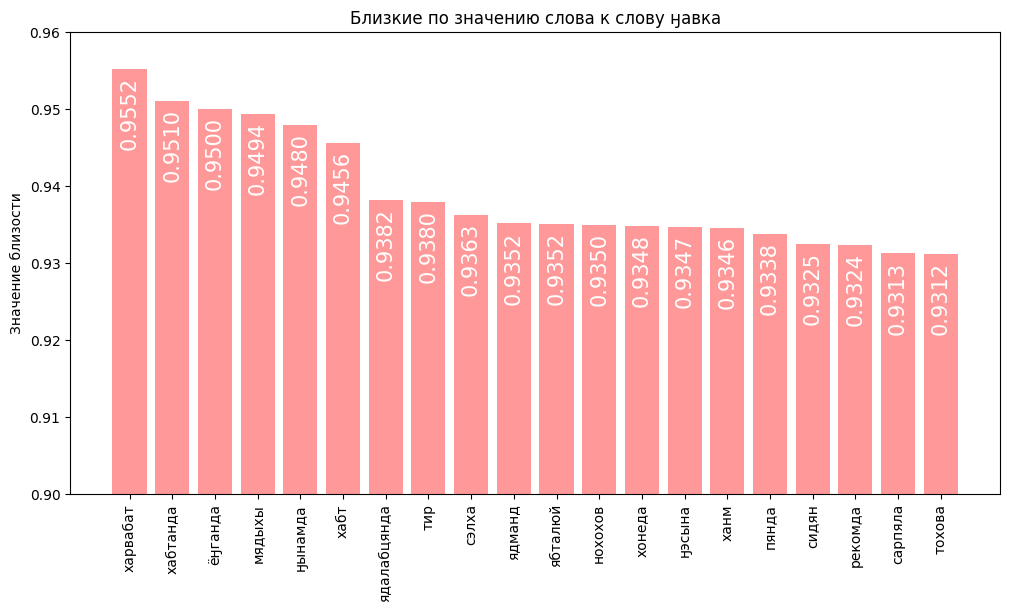

In [ ]:
import matplotlib.pyplot as plt

# Получение списка наиболее похожих слов и их значений сходства
similar_words = model.wv.most_similar('ӈавка', topn=20)
similarities = [similarity for word, similarity in similar_words]
words = [word for word, similarity in similar_words]

# Построение столбчатой диаграммы
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(words, similarities, color='#ff9999')
ax.set_title("Близкие по значению слова к слову ӈавка")
ax.set_ylabel('Значение близости')
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation=90)
ax.set_ylim([0.9, 0.96])

# Добавление надписей внутри столбцов
for i, similarity in enumerate(similarities):
    ax.text(i, similarity - 0.01, f'{similarity:.4f}', ha='center',
            fontsize=15, rotation=90, color='white')

plt.show()

Если значение сходства равно единице, значит слова полностью совпадают и наоборот, если значение приближено к нулю. Как можно заметить самое близкое слово «хабт» так же означает оленя (кастрированного), оно может употребляться в различном контексте при добавлении других ненецких слов ([источник](https://books.google.ru/books?id=jttNmQEACAAJ)).

In [ ]:
for word, similarity in model.wv.most_similar('мядонзэй', topn=10):
    print(word, f"{similarity:.4f}", end=". ")

паромбась 0.9717. нув’сармик 0.9715. манэ’’лабтамба 0.9701. яха’’на 0.9699. мел’’мана 0.9698. ёльцяда 0.9683. посёлкаха’’на 0.9679. падвэвната 0.9677. тарабта 0.9657. ядэрмани 0.9657. 

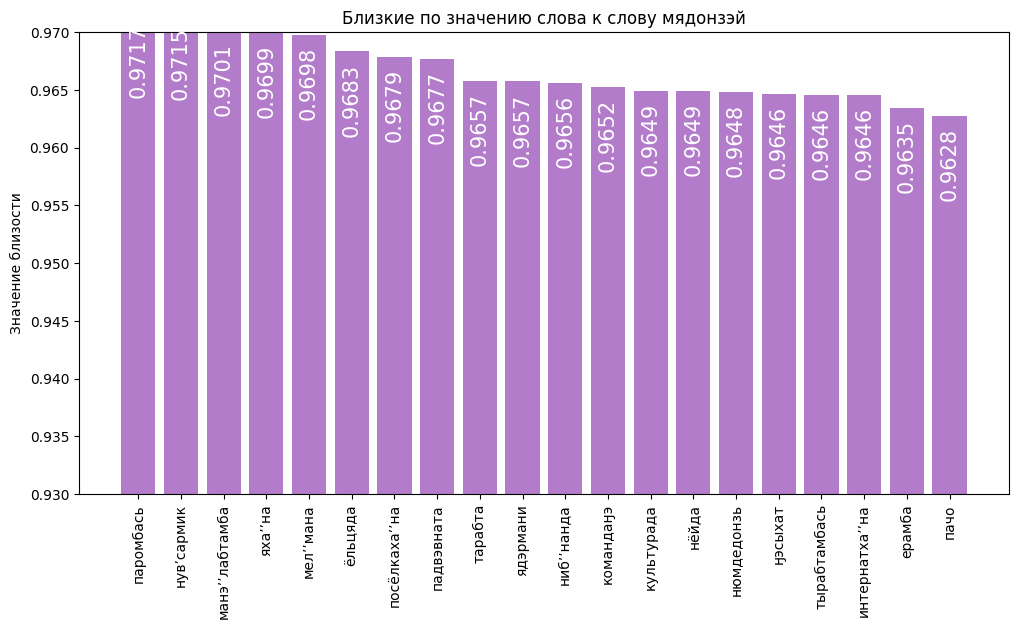

In [ ]:
similar_words = model.wv.most_similar('мядонзэй', topn=20)
similarities = [similarity for word, similarity in similar_words]
words = [word for word, similarity in similar_words]

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(words, similarities, color='#B37CCA')
ax.set_title("Близкие по значению слова к слову мядонзэй")
ax.set_ylabel('Значение близости')
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation=90)
ax.set_ylim([0.93, 0.97])

for i, similarity in enumerate(similarities):
    ax.text(i, similarity - 0.007, f'{similarity:.4f}', ha='center',
            fontsize=15, rotation=90, color='white')

plt.show()

## **Кластеризация записей**

Кластеризацией называют процесс группировки схожих записей в кластеры на основе сходства их содержимого. Этот процесс может быть полезен для выявления тематических групп в наборе записей или для поиска похожих записей.

In [ ]:
from sklearn.cluster import KMeans

# Проведение векторизации записей
vectors = np.array([np.mean([model.wv[word] for word in words if word in model.wv]
                            or [np.zeros(model.vector_size)], axis=0)
                            for words in processed_texts])

# Кластеризация записей
kmeans = KMeans(n_clusters=3, random_state=42, n_init=5)
clusters = kmeans.fit_predict(vectors)

# Отображение соответствия каждой записи кластеру
# for i in range(len(clusters)):
#     print(f"Text {i} belongs to cluster {clusters[i]}")

In [ ]:
# Оценка качества кластеризации с помощью silhouette_score
from sklearn.metrics import silhouette_score

silhouette_score(vectors, clusters)

0.43304378

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg_cluster = AgglomerativeClustering(n_clusters=2, linkage='ward',
                                      metric='euclidean')

clusters = agg_cluster.fit_predict(vectors)

# for i in range(len(clusters)):
#     print(f"Text {i} belongs to cluster {clusters[i]}")

In [ ]:
silhouette_score(vectors, clusters)

0.63572794

## **Реализация частотного словаря слов ненецкого языка**

In [ ]:
from collections import defaultdict, Counter

# Создание пустого словаря
word_freq = defaultdict(int)

# Подсчет количества вхождений каждого слова в каждой записи
for text in processed_texts:
    for word in text:
        word_freq[word] += 1

# Создание объекта Counter из частотного словаря слов
word_counts = Counter(word_freq)

# Выбор 500 наиболее часто встречающихся слов
top_words = word_counts.most_common(500)

# Вывод списка наиболее часто встречающихся слов
for word, freq in top_words:
    print(word, freq)

тикы 905
ӈарка 838
тамна 796
тарця 700
нямна 644
пыда 596
хусувэй 569
похона 568
таняна 506
яля 460
ӈока 450
няна 443
ӈопой 403
хомана 369
падвы 362
ӈани 349
ха 336
я 330
няръяна 328
ӈайта 323
ёльце 322
мэта 317
сава 308
едэй 307
саць 294
няби 290
маль 273
по 271
ӈэда 258
хуркари 254
харда 244
таԓям 243
чуки 242
вы 241
ӈамгэ 240
вада 232
эмня 225
ӈацекы 225
хасава 210
выӈкна 209
тэри 203
ненэцие 198
школа 197
пудана 196
ӈобтикы 195
нюртей 188
шанат 186
нюдя 181
хэбидя 180
тика 177
мя 177
айваседо 171
хой 165
хурка 163
ёльця 163
пир 161
мар 160
салехарда 157
камна 156
хэв 153
ӈоб 147
район 146
тамаль 146
манԓе 146
минрена 145
самляӈг 143
манзара 137
нюбета 137
ӈадьбята 135
ӈэва 135
нгэрм 134
ниць 133
нида 133
ӈука 132
тиртя 131
мэць 126
шича 123
ю 123
ханяӈэ 122
вэва 121
таньше 120
сямянхат 119
пыта 119
ила 118
ненэця 115
саво 115
шаӈкмян 114
тохолко 113
тонԓюта 113
таславы 112
хибя 109
илаӈгы 109
тя 108
си”ив 108
е’’эмня 107
мюня 107
хэвы 105
тайня 102
илена 101
сертавы 101
товы 101
ир

## **Результаты**

### **Объем источников в наборе данных**

Объем каждого источника в необработанном наборе данных представлен в виде круговой диаграммы.

Подобранный необработанный набор данных имеет 2367 записей и два признака, обозначающих ранее определенный в используемых наборах данных признак "text" и ссылка "link" на содержащий данные источник. В "text" имеются ненецкие, русские и английские слова, хэштеги, эмодзи, аббревиатуры, ссылки, элементы в квадратных скобках и другие спецсимволы.

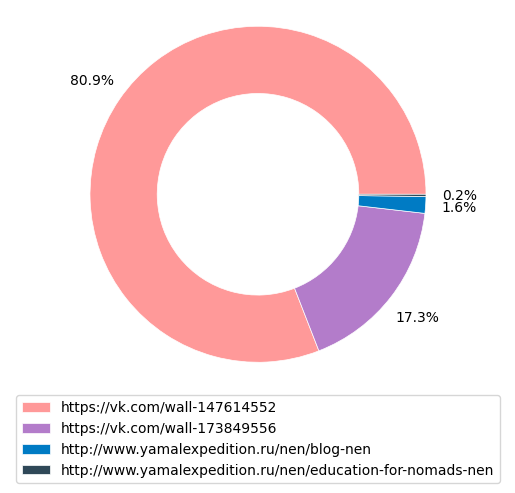

In [ ]:
# Подсчет количества ссылок в каждом источнике
counts = df_link_1.value_counts()

colors = ['#ff9999','#B37CCA','#007BC4','#2F4858']

# Построение круговой диаграммы
plt.pie(counts.values, labels=None, autopct='%1.1f%%', pctdistance=1.2,
        colors=colors, wedgeprops={'linewidth': 0.5,
                                   'edgecolor': 'white','width': 0.4})

# Добавление легенды
plt.legend(counts.index, loc="lower center", bbox_to_anchor=(0.5, -0.3))

plt.axis('equal')
plt.show()

После предложенных преобразований набор данных имеет 2 признака и 1191 запись. Данные имеют только корректные слова из букв ненецкого алфавита и символов, обозначающих гортанную смычку, в случае если текст не имел опечаток и слова были написаны через пробельный символ.
Объем каждого из источников так же изменился.

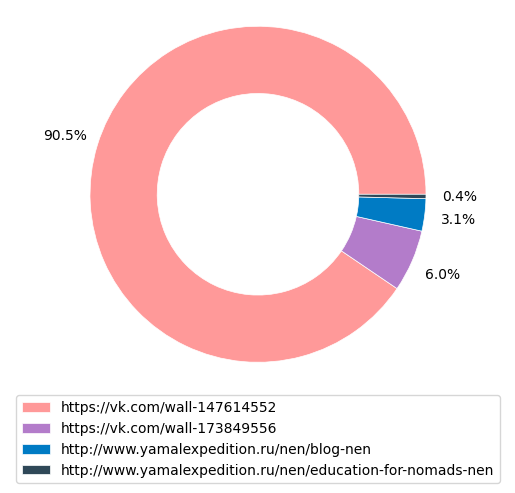

In [ ]:
counts = df_link_2.value_counts()
colors = ['#ff9999','#B37CCA','#007BC4','#2F4858']

plt.pie(counts.values, labels=None, autopct='%1.1f%%', pctdistance=1.2,
        colors=colors, wedgeprops={'linewidth': 0.5,
                                   'edgecolor': 'white','width': 0.4})

plt.legend(counts.index, loc="lower center", bbox_to_anchor=(0.5, -0.3))

plt.axis('equal')
plt.show()

### **Визуализация кластеризации**

Далее происходит разбиение записей на 2-3 кластера на основе близости векторов.

Для оценки качества кластеризации ограничимся лишь коэффициентом силуэт ([источник](https://scikit-learn.ru/clustering)). Значение коэффициента силуэта ближе к 1 означает, что кластеры хорошо разделены, ближе к 0 - что кластеры пересекаются, если значение достигает -1 — объекты неправильно отнесены к кластерам.

Разбиение с помощью Agglomerative Clustering на 2 кластера дает коэффициент силуэта, равный 0,63, что делает его более качественным, по сравнению с другими (например, значение силуэта при использовании K-Means с 3 кластерами дает значение 0,45, что указывает на то, что кластеры имеют значительное перекрытие и не являются сильно отделенными друг от друга.). Можно заметить, что кластеры располагаются недостаточно плотно, но за счет того, что кластера стало 2, они стали визуально разделяться.

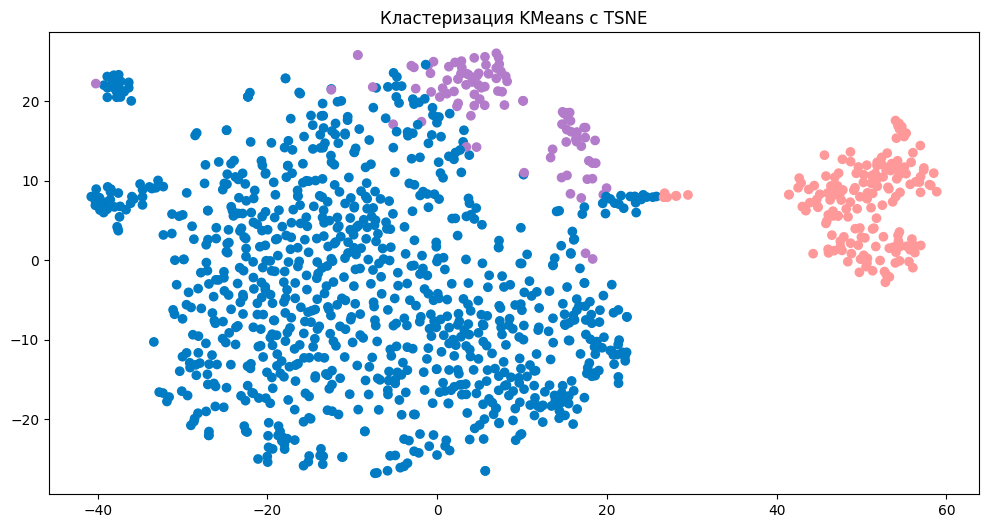

In [ ]:
from sklearn.manifold import TSNE

# Создание объекта класса TSNE
tsne = TSNE(n_components=2, random_state=0)

# Применение метода к векторам документов
vectors_tsne = tsne.fit_transform(vectors)

# Создание графика
plt.figure(figsize=(12,6))
plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1],
            c=[colors[label] for label in kmeans.labels_])
plt.title('Кластеризация KMeans с TSNE')
plt.show()

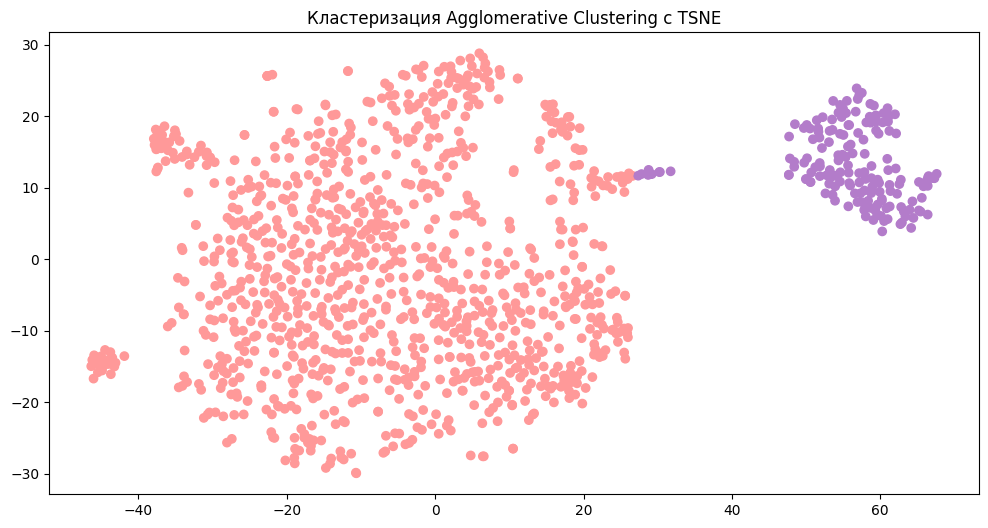

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, early_exaggeration=12,
            learning_rate=200, n_iter=1000, random_state=42)

tsne_vectors = tsne.fit_transform(vectors)

plt.figure(figsize=(12,6))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1],
            c=[colors[label] for label in agg_cluster.labels_])
plt.title('Кластеризация Agglomerative Clustering с TSNE')
plt.show()

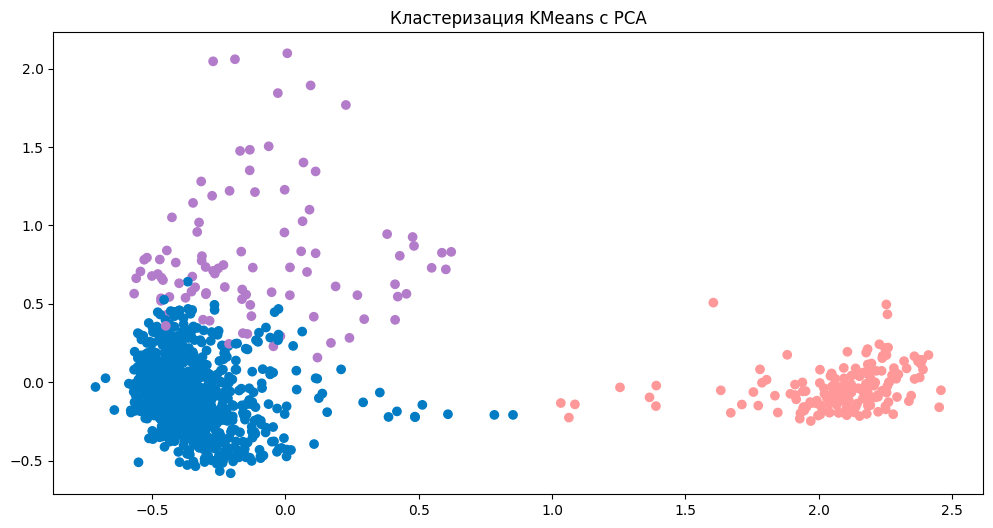

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

vectors_pca = pca.fit_transform(vectors)

plt.figure(figsize=(12,6))
plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1],
            c=[colors[label] for label in kmeans.labels_])
plt.title('Кластеризация KMeans с PCA')
plt.show()

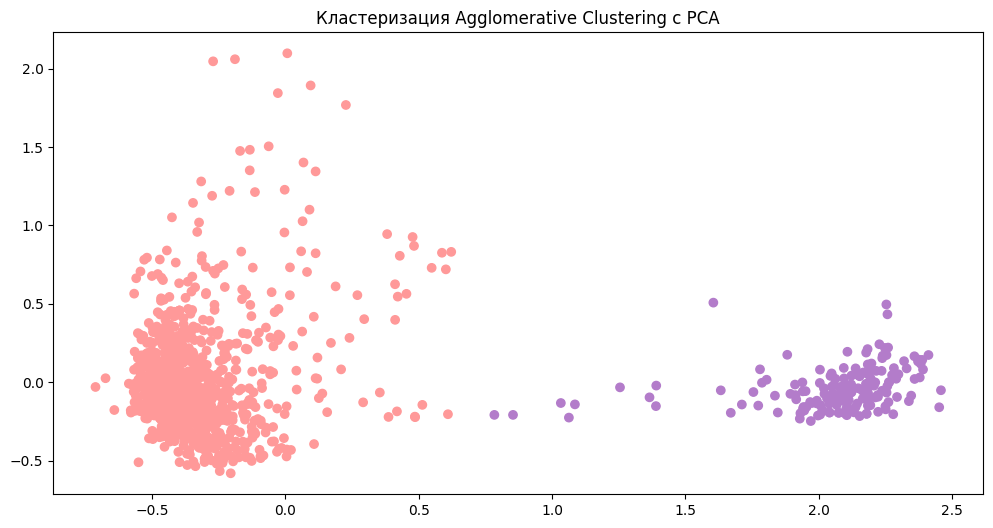

In [ ]:
pca = PCA(n_components=2)

vectors_pca = pca.fit_transform(vectors)

plt.figure(figsize=(12,6))
plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1],
            c=[colors[label] for label in agg_cluster.labels_])
plt.title('Кластеризация Agglomerative Clustering с PCA')
plt.show()

In [ ]:
import plotly.graph_objs as go

# Получение массива координат точек с помощью метода TSNE
tsne_coords = TSNE(n_components=2, random_state=0).fit_transform(vectors)

# Создание отдельных списков координат для каждого кластера
cluster_0_x, cluster_0_y = [], []
cluster_1_x, cluster_1_y = [], []

for i in range(len(clusters)):
    if clusters[i] == 0:
        cluster_0_x.append(tsne_coords[i][0])
        cluster_0_y.append(tsne_coords[i][1])
    else:
        cluster_1_x.append(tsne_coords[i][0])
        cluster_1_y.append(tsne_coords[i][1])

# Создание отдельных объектов для каждого кластера
cluster_0 = go.Scatter(
    x=cluster_0_x,
    y=cluster_0_y,
    mode='markers',
    name='Cluster 1',
    marker=dict(
        size=10,
        color='#ff9999',
    )
)

cluster_1 = go.Scatter(
    x=cluster_1_x,
    y=cluster_1_y,
    mode='markers',
    name='Cluster 2',
    marker=dict(
        size=10,
        color='#B37CCA',
    )
)

data = [cluster_0, cluster_1]
fig = go.Figure(data=data)
fig.show()

### **Визуализация частотного словаря**


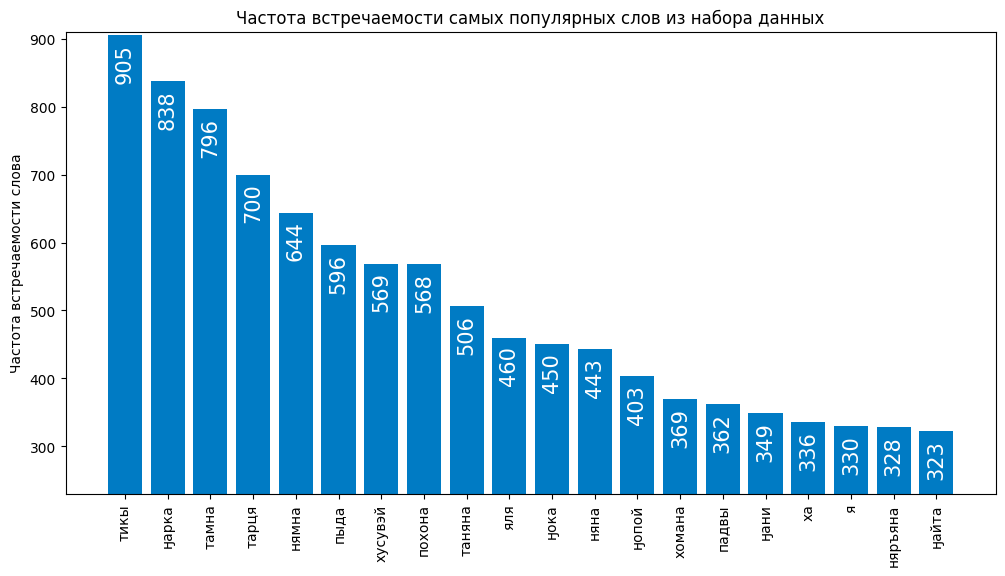

In [ ]:
from collections import Counter

# Сбор всех слов в единый список
all_words = [word for doc in df['text'] for word in doc.split()]

# Подсчет количества вхождений каждого слова
word_counts = Counter(all_words)

# Выбор наиболее часто встречающихся слов
top_words = word_counts.most_common(20)

# Создание списков слов и их частот
words = [word[0] for word in top_words]
freqs = [word[1] for word in top_words]

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(words, freqs, color='#007BC4')
ax.set_ylabel('Частота встречаемости слова')
ax.set_title('Частота встречаемости самых популярных слов из набора данных')
plt.xticks(rotation=90)
ax.set_ylim([230, 910])

for i, count in enumerate(freqs):
    ax.text(i, count - 65, f'{count:.0f}', ha='center', fontsize=15,
            rotation=90, color='white')
plt.show()

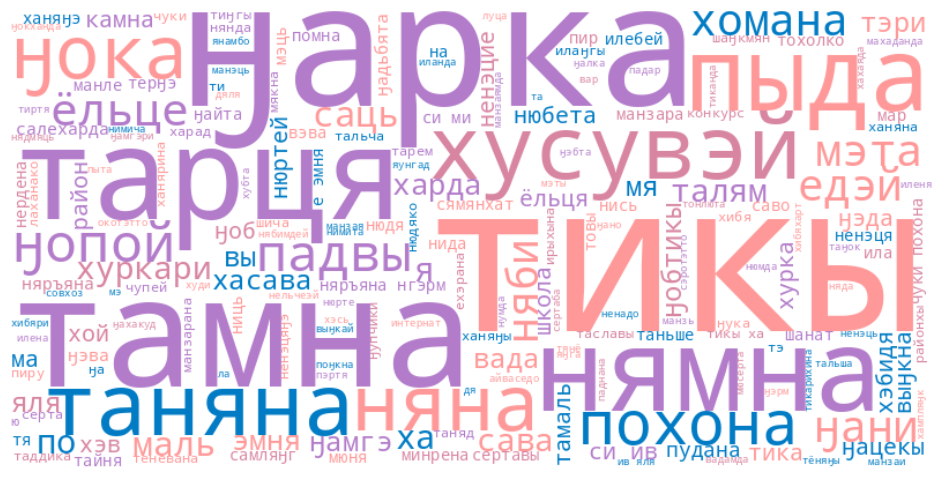

In [ ]:
from wordcloud import WordCloud

# Функция для раскраски слов
def color_func(word, font_size, position, orientation, random_state=None,
               **kwargs):
    colors = ['#ff9999','#B37CCA','#007BC4','#D885A2']
    return colors[len(word) % len(colors)]

# Создание объекта облака слов
wordcloud = WordCloud(background_color='white', width=800, height=400,
                      color_func=color_func)

# Генерация облака слов
wordcloud.generate(' '.join(all_words))

# Отображение облака слов
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Этот блокнот посвящен анализу текстов на ненецком языке и является частью масштабной работы по изучению и сохранению этого языка. В рамках исследования был составлен частотный словарь ненецких слов на основе данных из ВКонтакте (VK API) и материалов этнографической экспедиции «Настоящие люди». Для обработки текстов использованы библиотеки Python: NumPy, pandas, re, а морфологический анализатор pymorphy3 применялся для удаления русских слов.

Кроме того, проведены ключевые этапы анализа текстовых данных: предобработка, визуализация (Matplotlib, Plotly, WordCloud), построение векторной модели и кластеризация (KMeans, Agglomerative Clustering). Рассчитана контекстная близость ненецких слов, что расширяет возможности дальнейших исследований.

Таким образом, блокнот представляет информацию от сбора данных на ненецком языке до моделирования и визуализации, обеспечивая фундамент для дальнейших работ в этом направлении.